# MVTec-AD benchmark dataset on Unsupervised Quantum Anomaly Detection

Author : [Nishantak Panigrahi](https://github.com/nishantak)

---

Variational Quantum Anomaly Detector

Trains on normal data then "like an autoencoder", instead of reconstruction error, it uses:
- Measurement distribution of a quantum circuit as a metric

- Compares test distributions to a "normal" baseline using KL 



--- Training on 391 NORMAL samples ---



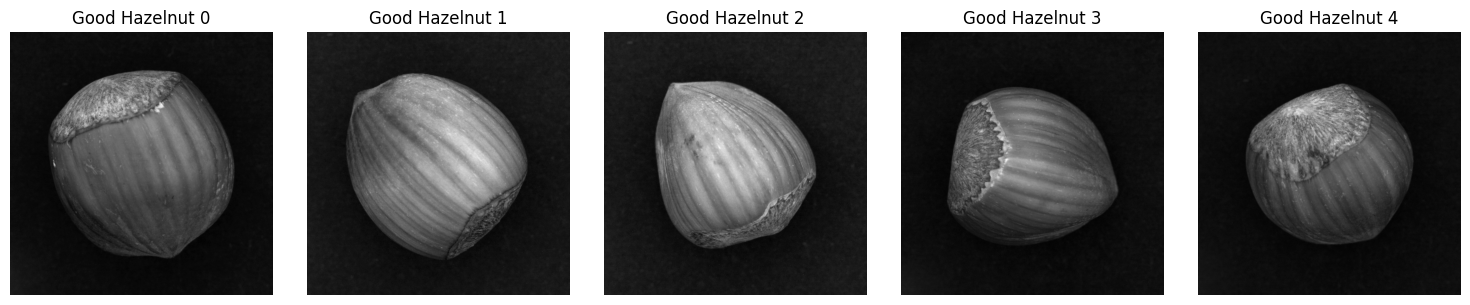


Testing quantum anomaly detection...


--- Set Baseline Divergence ---

Normal scores: mean=3.2108, std=0.2120

Testing quantum anomaly detection...


--- Testing on 70 ANOMOLOUS TEST samples ---

Test scores: mean=3.3301, std=0.3075

--- Testing on 40 GOOD TEST samples ---

Test scores: mean=3.1054, std=0.1612

Threshold: 3.5289
Detection accuracy: 50.00%
Good samples correctly classified: 40/40
Anomalous samples correctly classified: 15/70



Evaluating good samples: 100%|██████████| 40/40 [00:58<00:00,  1.47s/it]



=== CORRECTLY CLASSIFIED ANOMALIES ===


Visualizing Correct Anomaly:   0%|          | 0/3 [00:00<?, ?it/s]


Generating heatmap for Correct Anomaly Sample 1...
Segmenting image into superpixels...
Original anomaly score: 3.9772


Perturbing: 100%|██████████| 256/256 [08:04<00:00,  1.89s/it]


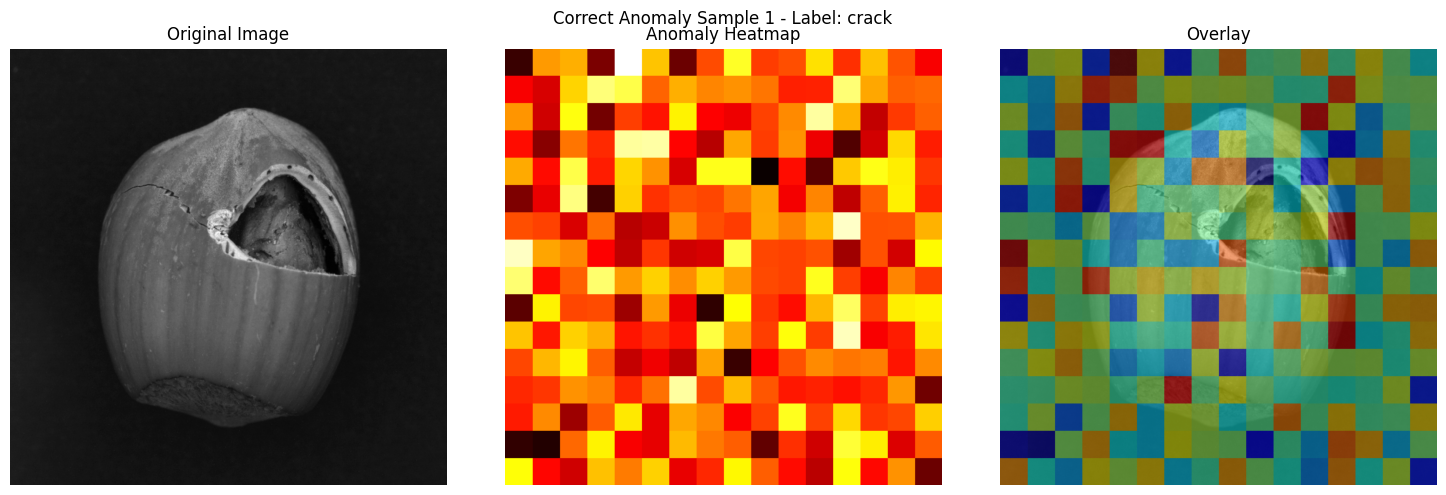

Visualizing Correct Anomaly:  33%|███▎      | 1/3 [08:07<16:14, 487.12s/it]


Generating heatmap for Correct Anomaly Sample 2...
Segmenting image into superpixels...
Original anomaly score: 3.6383


Perturbing: 100%|██████████| 256/256 [06:15<00:00,  1.47s/it]


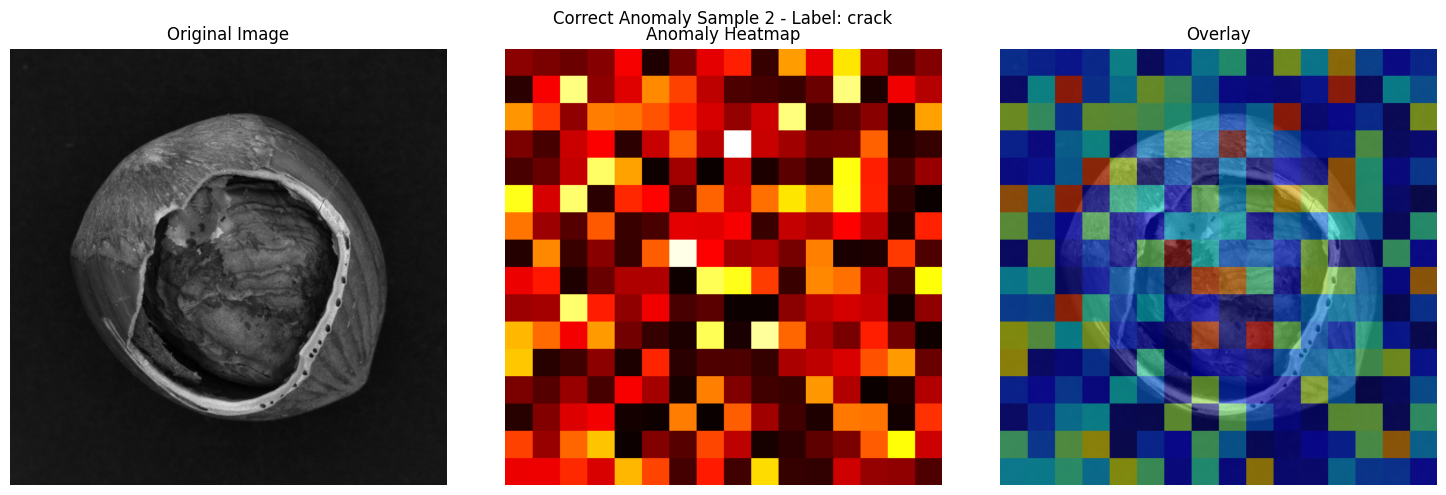

Visualizing Correct Anomaly:  67%|██████▋   | 2/3 [14:25<07:03, 423.30s/it]


Generating heatmap for Correct Anomaly Sample 3...
Segmenting image into superpixels...
Original anomaly score: 3.6948


Perturbing: 100%|██████████| 256/256 [06:59<00:00,  1.64s/it]


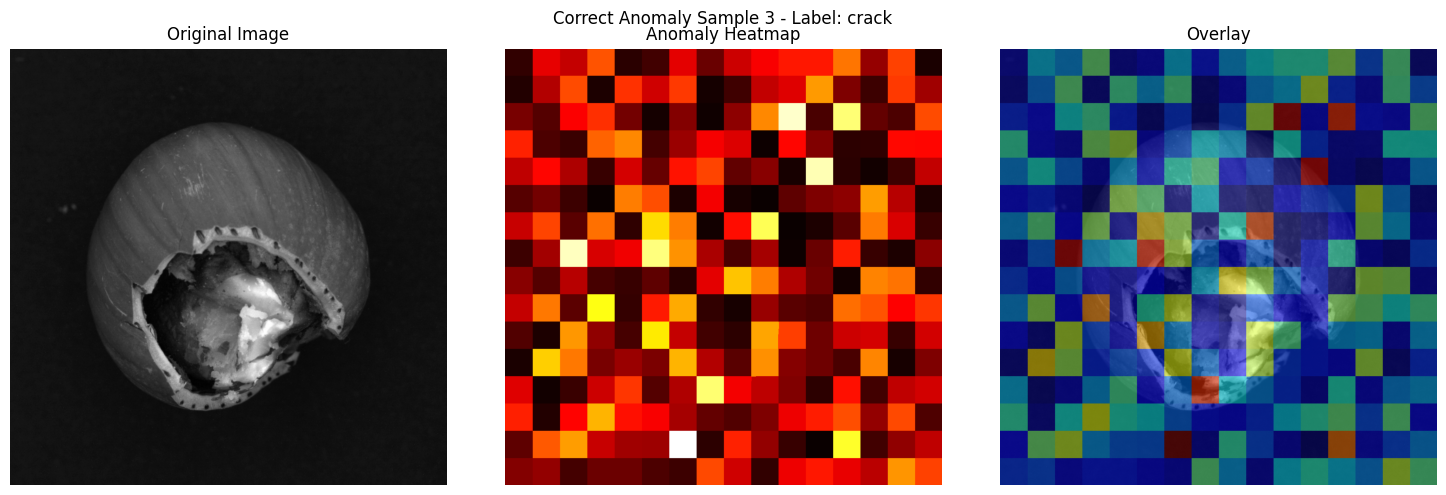

Visualizing Correct Anomaly: 100%|██████████| 3/3 [21:27<00:00, 429.20s/it]



=== INCORRECTLY CLASSIFIED ANOMALIES ===


Visualizing Incorrect Anomaly:   0%|          | 0/3 [00:00<?, ?it/s]


Generating heatmap for Incorrect Anomaly Sample 1...
Segmenting image into superpixels...
Original anomaly score: 3.4620


Perturbing: 100%|██████████| 256/256 [06:21<00:00,  1.49s/it]


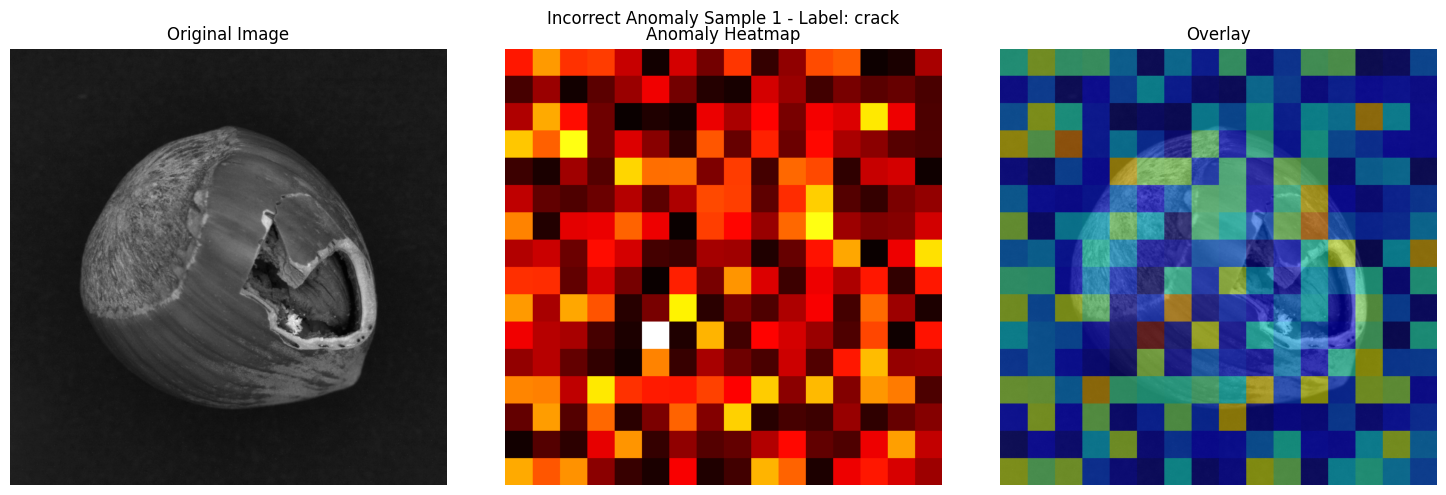

Visualizing Incorrect Anomaly:  33%|███▎      | 1/3 [06:23<12:47, 383.85s/it]


Generating heatmap for Incorrect Anomaly Sample 2...
Segmenting image into superpixels...
Original anomaly score: 3.5320


Perturbing: 100%|██████████| 256/256 [07:49<00:00,  1.83s/it]


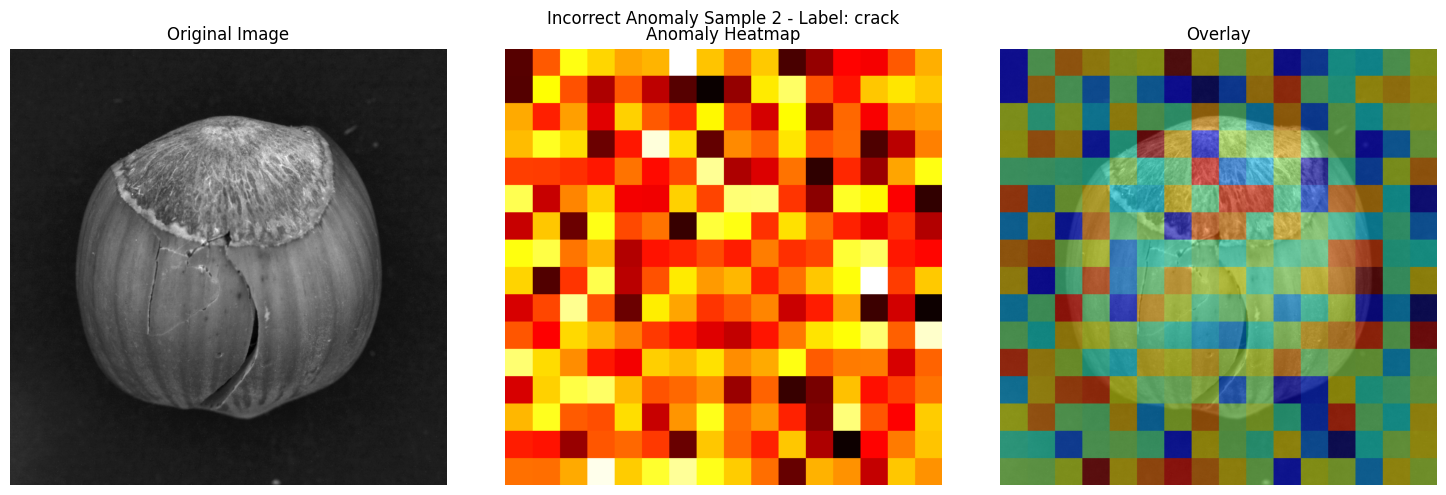

Visualizing Incorrect Anomaly:  67%|██████▋   | 2/3 [14:15<07:15, 435.63s/it]


Generating heatmap for Incorrect Anomaly Sample 3...
Segmenting image into superpixels...
Original anomaly score: 2.9468


Perturbing: 100%|██████████| 256/256 [06:30<00:00,  1.52s/it]


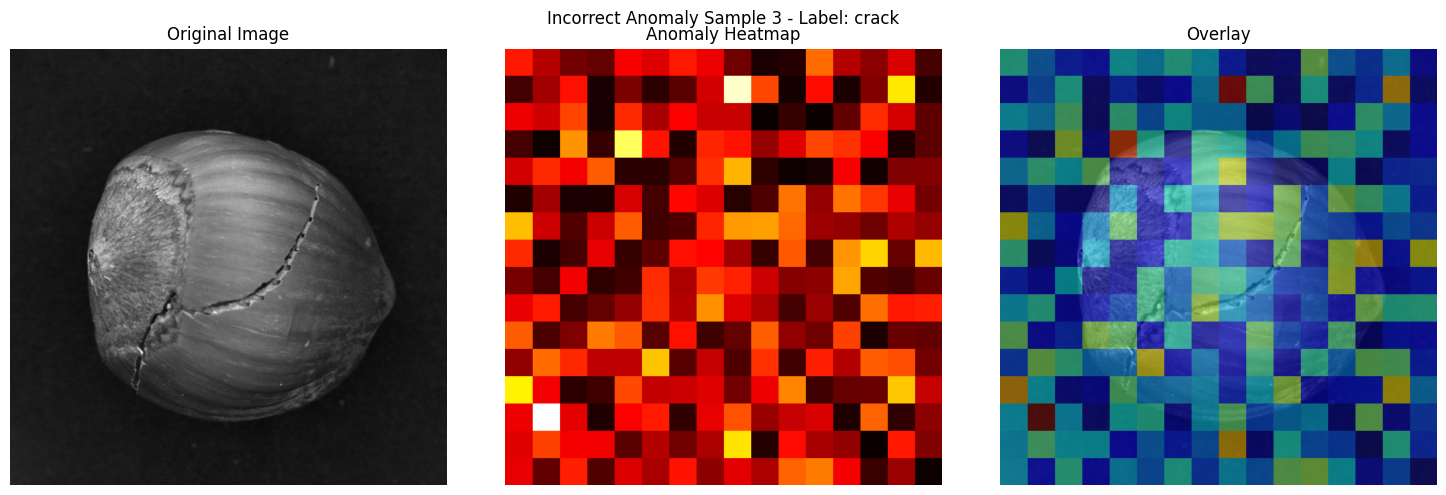

Visualizing Incorrect Anomaly: 100%|██████████| 3/3 [20:48<00:00, 416.20s/it]


In [11]:
# Imports
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator

# QC
class QuantumAnomalyDetector:
    def __init__(self, num_qubits=6, shots=1024):
        self.num_qubits = num_qubits
        self.shots = shots
        self.simulator = AerSimulator()
        self.baseline_distribution = None  # How normal is supposed to look, we train on nomral so it learns and we dont need to hardcode.
        
    
    # Classical data ---> Quantum State Vector : 2^num_qubits
    def encode_data(self, data):
        data = data.flatten()   # HAZELNUT: 1024 X 1024 -> 2^20
        
        target_size = 2**self.num_qubits  # number of amplitudes, 3 bits can represent 2^3 = 8 amplitudes = len(Quantum State Vector)

        # Feature selection
        
        # We can only encode N = 2^n values: like input layer of NN; either downsample or extract features and feed to num_qubits qubits (hybrid)
        # ∣\psi⟩ = a_0​ ∣000...0⟩ + a_1 ​∣000...1⟩ +...+ a_{N-1} ​∣11...11⟩
        if len(data) > target_size:
            step = len(data) // target_size     # Downsample by taking N elements across the image
            data = data[::step][:target_size]
        if len(data) < target_size: data = np.pad(data, (0, target_size-len(data)), mode='constant')
        data = data[:target_size]
        
        
        # Encoding: Amplitude Encoding

        # Normalisation || \sum{|a_i|^2} = 1 because <\psi | \psi> = 1 : Born Rule
        norm = np.linalg.norm(data) # L2 Norm / Euclidean Norm: ||x|| = \sqrt{\sum{x_i^2}}
        if norm > 1e-10:  # if no 0 division

            data = data / norm  # unit vector now: x -> x / ||X||  => ||x|| = 1
            
            # Double Check because Qiskit is rude and double perc floating point is the bane of society
            actual_norm = np.linalg.norm(data)
            if not np.isclose(actual_norm, 1.0, atol=1e-10): data = data / actual_norm

        # if 0 division
        else: data = np.ones(target_size) / np.sqrt(target_size)  # -> Equal amplitudes
        

        # Final check and correction for floating point errors
        final_norm = np.sum(np.abs(data)**2) # norm^2 
        if not np.isclose(final_norm, 1.0, atol=1e-12): data = data / np.sqrt(final_norm)
        return data
    

    # Detection Circuit
    def quantum_circuit(self, encoded_data):
        qreg = QuantumRegister(self.num_qubits, 'q') # inputs
        creg = ClassicalRegister(self.num_qubits, 'c') # outputs
        circuit = QuantumCircuit(qreg, creg)
        
        # Initialize quantum state with encoded data : ∣\psi⟩ = \sum_{i=0}^{2^N-1}{ x_{i} ​∣\psi_i⟩ }
        circuit.initialize(encoded_data, qreg, normalize=True)
        
        # Quantum feature map (VQC not PQC, circuit param not trained - distribution is trained) : gives "effect" of the data to meaasure and comapre

        # Rotation : R_y(\theta)(x)
        for i in range(self.num_qubits):
            circuit.ry(np.pi/4, qreg[i])
        # Entanglment
        for i in range(self.num_qubits - 1):
            circuit.cx(qreg[i], qreg[i+1])
            
        # Simulate noise for generalisation
        for i in range(self.num_qubits):
            if np.random.random() < 0.23: # Realistic hardware noise
                circuit.rx(np.random.uniform(0, np.pi/8), qreg[i])

        # Measure in computational basis
        circuit.measure(qreg, creg)
        return circuit
    

    # Training: Learns what is normal -> Establish baseline
    # How? : learnign how the distribution of measurements of the above circuit looks for normal data
    def train_baseline(self, normal_data):
        distributions = []
        for i, sample in enumerate(normal_data):
            encoded = self.encode_data(sample.flatten())
            circuit = self.quantum_circuit(encoded)

            # if not i: display(circuit.draw("latex"))
            
            # Pass through circuit
            compiled_circuit = transpile(circuit, self.simulator) # Qiskit real backends: transpile optimises the circuit optimised for the simulator backend.
            job = self.simulator.run(compiled_circuit, shots=self.shots) # experiment
            counts = job.result().get_counts(compiled_circuit) # Count of each \psi_i basis state: {'00..00': 200, '00..01': 180, ..., '11..11': 140}

            
            # Get probability distribution
            prob_dist = np.zeros(2**self.num_qubits)
            for state, count in counts.items():
                prob_dist[int(state, 2)] = count/self.shots
            distributions.append(prob_dist)

        self.baseline_distribution = np.mean(distributions, axis=0) # distribution mean, can also store additional measures of tendency such as median, sd etc.
        

    # How far from baseline?
    def detect_anomaly(self, test_data):
        encoded = self.encode_data(test_data.flatten())
        circuit = self.quantum_circuit(encoded)
        
        # Execute circuit for input data
        compiled_circuit = transpile(circuit, self.simulator)
        job = self.simulator.run(compiled_circuit, shots=self.shots)
        counts = job.result().get_counts(compiled_circuit)
        
        # Get probability distribution
        prob_dist = np.zeros(2**self.num_qubits)
        for state, count in counts.items():
            prob_dist[int(state, 2)] = count/self.shots
        
        # Calculate KL divergence from baseline
        if self.baseline_distribution is not None:
            epsilon = 1e-10     # avoid log(0)
            
            baseline_smooth = self.baseline_distribution + epsilon
            prob_dist_smooth = prob_dist + epsilon
            
            # D_{KL}(P||Q) = \sum_{i}{ P_i * log(P_i / Q_i) } 
            kl_div = np.sum(prob_dist_smooth * np.log(prob_dist_smooth / baseline_smooth))
            return kl_div



# Datset

train_dir = "hazelnut_mvtecad_dataset/train/good"
def load_train_images(path, size=(1024, 1024)): # hazelnut images are 1024x1024
    imgs = []
    for file in glob.glob(os.path.join(path, "*.png")):
        img = Image.open(file).convert('L').resize(size)
        imgs.append(np.array(img) / 255.0)  # Normalize to [0, 1], 8-bit: L mode
    return imgs
train_imgs = load_train_images(train_dir)


test_dir = "hazelnut_mvtecad_dataset/test"
def load_test_images(test_dir, size=(1024, 1024)):
    imgs = []
    labels = []
    good_imgs = []
    categories = ['crack', 'cut', 'hole', 'print']
    
    for category in categories:
        cat_dir = os.path.join(test_dir, category)
        for file in glob.glob(os.path.join(cat_dir, "*.png")):
            img = Image.open(file).convert('L').resize(size)
            img_array = np.array(img) / 255.0
            imgs.append(img_array)
            labels.append(category)  # track which kind of anomaly it is
    
    # good samples
    cat_dir = os.path.join(test_dir, "good")
    for file in glob.glob(os.path.join(cat_dir, "*.png")):
        good_img = Image.open(file).convert('L').resize(size)
        good_img_array = np.array(good_img) / 255.0
        good_imgs.append(good_img_array)
        
    return imgs, labels, good_imgs
test_imgs, test_labels, good_imgs = load_test_images(test_dir)



# Training
detector = QuantumAnomalyDetector(num_qubits=20)

# Show some samples
print(f"\n--- Training on {len(train_imgs)} NORMAL samples ---\n")
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(min(5, len(train_imgs))):
    axes[i].imshow(train_imgs[i].squeeze(), cmap='gray')
    axes[i].set_title(f'Good Hazelnut {i}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()
    
detector.train_baseline(train_imgs)

print("\nTesting quantum anomaly detection...\n")

print("\n--- Set Baseline Divergence ---")
normal_scores = []
for i, sample in enumerate(train_imgs):
    score = detector.detect_anomaly(sample) 
    normal_scores.append(score)

print(f"\nNormal scores: mean={np.mean(normal_scores):.4f}, std={np.std(normal_scores):.4f}")\



# Test on samples

# anomolous
print("\nTesting quantum anomaly detection...\n")
print(f"\n--- Testing on {len(test_imgs)} ANOMOLOUS TEST samples ---\n")
anomaly_scores = []
for i, sample in enumerate(test_imgs):
    score = detector.detect_anomaly(sample)
    anomaly_scores.append(score)

print(f"Test scores: mean={np.mean(anomaly_scores):.4f}, std={np.std(anomaly_scores):.4f}")

# good
print(f"\n--- Testing on {len(good_imgs)} GOOD TEST samples ---\n")
good_scores = []
for i, sample in enumerate(good_imgs):
    score = detector.detect_anomaly(sample)
    good_scores.append(score)

print(f"Test scores: mean={np.mean(good_scores):.4f}, std={np.std(good_scores):.4f}")

threshold = np.mean(normal_scores) + 1.5*np.std(normal_scores) # VIT Metrics
print(f"\nThreshold: {threshold:.4f}")

good_correct = sum(1 for score in good_scores if score<threshold)
anomaly_correct = sum(1 for score in anomaly_scores if score>=threshold)

total_samples = len(good_scores) + len(anomaly_scores)

accuracy = (good_correct + anomaly_correct) / total_samples

print(f"Detection accuracy: {accuracy:.2%}")

print(f"Good samples correctly classified: {good_correct}/{len(good_scores)}")
print(f"Anomalous samples correctly classified: {anomaly_correct}/{len(anomaly_scores)}\n")



# Inference | Mutual Information-like visual expression measure using patch pertubration on superpixels
from tqdm import tqdm
from skimage.segmentation import slic

def generate_superpixel_anomaly_heatmap(detector, image, n_segments=256, compactness=4):
    print("Segmenting image into superpixels...")
    segments = slic(image, n_segments=n_segments, compactness=compactness, start_label=0, channel_axis=None)
    h, w = image.shape
    heatmap = np.zeros((h, w))

    original_score = detector.detect_anomaly(image)
    print(f"Original anomaly score: {original_score:.4f}")

    for label in tqdm(np.unique(segments), desc="Perturbing"):
        perturbed = image.copy()
        perturbed[segments == label] = 0.0
        perturbed_score = detector.detect_anomaly(perturbed)
        delta = np.abs(perturbed_score - original_score)
        heatmap[segments == label] = delta
    return heatmap

correct_anomalies = []
incorrect_anomalies = []
for i, (img, label) in tqdm(enumerate(zip(test_imgs, test_labels)), total=len(test_imgs), desc="Evaluating anomalies"):
    score = detector.detect_anomaly(img)
    is_anomaly = score >= threshold
    if is_anomaly: correct_anomalies.append((img, label, score))
    else: incorrect_anomalies.append((img, label, score))

correct_goods = []
for img in tqdm(good_imgs, desc="Evaluating good samples"):
    score = detector.detect_anomaly(img)
    if score < threshold: correct_goods.append((img, score))


def visualize_heatmaps(samples, title_prefix, count=3):
    for i, (img, label_or_score, _) in tqdm(list(enumerate(samples[:count])), desc=f"Visualizing {title_prefix}"):
        print(f"\nGenerating heatmap for {title_prefix} Sample {i+1}...")
        heatmap = generate_superpixel_anomaly_heatmap(detector, img)

        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(img, cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap='hot')
        plt.title("Anomaly Heatmap")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(img, cmap='gray')
        plt.imshow(heatmap, cmap='jet', alpha=0.5)
        plt.title("Overlay")
        plt.axis('off')

        plt.suptitle(
            f"{title_prefix} Sample {i+1} - Score: {label_or_score:.4f}"
            if isinstance(label_or_score, float)
            else f"{title_prefix} Sample {i+1} - Label: {label_or_score}"
        )
        plt.tight_layout()
        plt.show()

print("\n=== CORRECTLY CLASSIFIED ANOMALIES ===")
visualize_heatmaps(correct_anomalies, title_prefix="Correct Anomaly")

print("\n=== INCORRECTLY CLASSIFIED ANOMALIES ===")
visualize_heatmaps(incorrect_anomalies, title_prefix="Incorrect Anomaly")

*Purely quantum circuit has inductive bias of nonlocal correlations. So, it cannot seggregate observable anomalies well, as they are structurally similar to normal images - in some space, as evident by their distributions having similar measures of central tendencies. Leading to this poor performance. Even if it correctly classifies them, it only knows that there is an issue, not where is the issue. Also, the training time!!*

---

Hybrid-QAE: Now, we have to make a choice!

| Aspect                          | CNN --> Quantum                                     | Quantum --> CNN                            |
| ------------------------------- | ------------------------------------------------- | ---------------------------------------- |
| **Input**                       | Feature vector from CNN                           | Raw (or lightly processed) image         |
| **Quantum's role**              | Quantum model for CNN feature output                  | Feature extraction / enrichment, global nonlinear transform |
| **Training feasibility**        | Easier, fewer qubits                              | Harder                                   |
| **Quantum advantage potential** | Less (quantum sees already-processed data)        | Higher (quantum transforms raw patterns) |
| **Scalability**                 | More scalable (qubit count depends on CNN output) | Limited by qubit count (encoding)        |
| **Use-Case**                    | High-resolution images, pixel-wise / lcoalised interpretaion | Quantum-representation methods to extract hidden interactions |


Data is simple, anomaly is visible. This motivates us to go from CNN --> Quantum.

Problem: QAEs are global -> they encode the image or features as a whole -> no local anomaly detection -> can't tell where the hazelnut defect is, + We saw that fail ^

Solution:

- Use CNN encoder to extract spatial feature maps --> retain local structure.

- Process through quantum autoencoder.

In [2]:
# Let's learn from previous mistakes and index the dir correctly, and get all the information wherever we can, regardless of whether it seems useful or not. 
import os
root = 'hazelnut_mvtecad_dataset'
dataset_structure = {
    f"{root}": {
        "ground_truth": ["crack", "cut", "hole", "print"],
        "test": ["crack", "cut", "good", "hole", "print"],
        "train": ["good"]
    }
}
dataset_structure # TIL python pretty prints

{'hazelnut_mvtecad_dataset': {'ground_truth': ['crack',
   'cut',
   'hole',
   'print'],
  'test': ['crack', 'cut', 'good', 'hole', 'print'],
  'train': ['good']}}

Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, TensorDataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

import matplotlib.pyplot as plt

import numpy as np
from PIL import Image
import cv2
import glob
from tqdm import tqdm

cuda


Dataset

In [3]:
IMG_DIM = 128 # smaller -> faster
class MVTecHazelnutDataset(Dataset):
    def __init__(self, root_dir, mode='train', transform=None):
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform

        if mode == 'train': self.img_paths = sorted(glob.glob(os.path.join(root_dir, 'train/good/*.png')))
        elif mode == 'test': self.img_paths = sorted(glob.glob(os.path.join(root_dir, 'test/**/*.*'), recursive=True))
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')  # CNN supremacy
        if self.transform:
            img = self.transform(img)
        return img, img_path
    
transform = transforms.Compose([
    transforms.Resize((IMG_DIM, IMG_DIM)), 
    transforms.ToTensor(),
])

train_dataset = MVTecHazelnutDataset(root, mode='train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = MVTecHazelnutDataset(root, mode='test', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

CNN feature extraactor (frozen)

In [4]:
class CNNEncoder(nn.Module):
    def __init__(self, output_dim=64):
        super().__init__()
        resnet = models.resnet18(pretrained=True) # gives 512 channels with H/32, W/32 spatial size due to downsampling

        layers = list(resnet.children())[:-2]  # Remove avgpool and fc --> feature extraction only, no classification
        
        self.feature_extractor = nn.Sequential(*layers)
        
        self.project = nn.Conv2d(512, output_dim, 1)  # Project to lower dim feature map

    def forward(self, x):
        # freeze weights
        with torch.no_grad():
            features = self.feature_extractor(x)  # (Batch size, 512, H/32, W/32)
        return self.project(features)  # (B, D, H', W')

def extract_patches(feature_map):
    B, C, H, W = feature_map.shape
    patches = feature_map.permute(0, 2, 3, 1).reshape(-1, C)    #  ---> (B × H × W, C): so,  B images of H X W pixels, each pixel described by a C dimensional feature vector
    return patches, H, W     # each patch is a local descriptor 

Quantum AutoEncoder: Another Choice Arises

| **Aspect**                                 | **Quantum Decoder Only**                       | **Full Quantum Autoencoder (Encoder + Decoder)**                           |
| ------------------------------------------ | ------------------------------------------------------- | --------------------------------------------------------------- |
| **Architecture**                           | Classical encoder (CNN) -> Quantum decoder (PQC)         | Classical encoder (CNN) -> Quantum encoder + decoder (PQC + PQC) |
| **Quantum Involvement**                    | Only decoder                              | Both, encoder and decoder                               |
| **Reconstruction error used for anomaly?** |  Yes                                                   | Same                                                           |
| **Pixel-wise heatmap?**                    | Yes (via patch-wise reconstruction error)             | Same                                           |
| **Qquantum latent space?**          | No. latent space is classical (CNN output)           | Yes. PQC learns quantum latent embeddings from CNN output                    |
| **Anomaly detection sensitivity**          | Good if classical encoder is strong                  | Potentially better in case of very weird / subtle anomalies due to more expressive latent space             |


I think the decoder only architecture can suffice (or work better) for our task. 

PQC Decoder

In [5]:
import pennylane as qml
from pennylane import numpy as pnp

N_LAYERS = 2
NUM_QUBITS = 4

qlayer_dev = qml.device("lightning.qubit", wires=NUM_QUBITS)

In [6]:
@qml.qnode(qlayer_dev, interface="torch")
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(NUM_QUBITS))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(NUM_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(NUM_QUBITS)]

class QuantumDecoder(nn.Module):
    def __init__(self, input_dim=64):
        super().__init__()
        self.input_dim = input_dim

        self.classical_proj = nn.Linear(input_dim, NUM_QUBITS) # reduce 64 -> 4 (for quantum input)

        # Quantum layer
        weight_shape = {"weights": (N_LAYERS, NUM_QUBITS, 3)}
        self.q_layer = qml.qnn.TorchLayer(quantum_circuit, weight_shape)

        self.post_q_proj = nn.Linear(NUM_QUBITS, input_dim) # 4 -> 64 (for reconstruction)

    def forward(self, z):                    # z: (B, 64)
        z_proj = self.classical_proj(z)      # (B, 6)
        q_out = self.q_layer(z_proj)         # (B, 6)
        out = self.post_q_proj(q_out)        # (B, 64)
        return out

Training

In [7]:
# _Encode_
cnn_encoder = CNNEncoder(output_dim=64).to(device)
feature_patches = []
for img, _ in train_loader:
    img = img.to(device)
    features = cnn_encoder(img)
    patches, _, _ = extract_patches(features)
    feature_patches.append(patches.detach())
inp_data = torch.cat(feature_patches, dim=0).to(device)

# Load patches
BATCH_SIZE = 2048  # numerical, tabular data can be handled in larger batches, the dataset itself is not large enough to cause memory issues: batching can give better regularisation
inp_dataset = TensorDataset(inp_data)
inp_loader = DataLoader(inp_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Decode
qae = QuantumDecoder(input_dim=64).to(device)
optimizer = torch.optim.Adam(qae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
epochs = 64 # less epochs; cannot run at ~0.75-1 hour per epoch
print(f"Training on {len(inp_data)} patches with batch size {BATCH_SIZE}")
for epoch in tqdm(range(epochs), desc="Training Epochs"):
    total_loss = 0.0
    for batch in inp_loader:
        x = batch[0].to(device)
        recon = qae(x)
        loss = loss_fn(recon, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    avg_loss = total_loss / len(inp_data)
    if not epoch or not (epoch+1)%4: print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

C:\Users\89\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\89\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training on 6256 patches with batch size 2048


Training Epochs:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.9883
Epoch 4 - Loss: 1.0306
Epoch 8 - Loss: 0.8961
Epoch 12 - Loss: 0.9344
Epoch 16 - Loss: 0.8421
Epoch 20 - Loss: 0.8738
Epoch 24 - Loss: 0.7824
Epoch 28 - Loss: 0.7943
Epoch 32 - Loss: 0.6822
Epoch 36 - Loss: 0.6740
Epoch 40 - Loss: 0.5952
Epoch 44 - Loss: 0.6270
Epoch 48 - Loss: 0.5883
Epoch 52 - Loss: 0.5683
Epoch 56 - Loss: 0.6082
Epoch 60 - Loss: 0.5895
Epoch 64 - Loss: 0.5514


1 Epoch took 59 minutes 40 seconds???? Cannot use quantum circuit with these many patches, let's downsample to see if it is actaully any good!
Get on linux and get a gpu simulator

Testing and Inference

In [8]:
import random
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

def get_ground_truth_mask(img_path):
    cls = os.path.basename(os.path.dirname(img_path))
    
    if cls == "good": return np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)

    fname = os.path.splitext(os.path.basename(img_path))[0]
    mask_path = os.path.join(root, 'ground_truth', cls, fname + '_mask.png')
    if os.path.exists(mask_path): return cv2.resize(cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE), (IMG_DIM, IMG_DIM), interpolation=cv2.INTER_NEAREST) // 255

    print(f"[WARN] Missing mask: {mask_path}")
    return np.zeros((IMG_DIM, IMG_DIM), dtype=np.uint8)

def reconstruct_heatmap(errors, H, W):
    heatmap = errors.reshape(H, W).detach().cpu().numpy()
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min() + 1e-8)
    heatmap = cv2.resize(heatmap, (IMG_DIM, IMG_DIM))
    return heatmap

def visualize(image_tensor, heatmap, binary_mask, gt_mask, title=""):
    image_np = image_tensor.permute(1, 2, 0).cpu().numpy()
    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min() + 1e-8)

    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image_np)
    plt.title("Input")

    plt.subplot(1, 4, 2)
    plt.imshow(image_np)
    plt.imshow(heatmap, cmap='hot', alpha=0.6)
    plt.title("Heatmap")

    plt.subplot(1, 4, 3)
    plt.imshow(binary_mask, cmap='gray')
    plt.title("Predicted Mask")

    plt.subplot(1, 4, 4)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth Mask")

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [9]:
def run_inference(image, encoder, qae):
    features = encoder(image.unsqueeze(0).to(device))  # (1, 64, IMG_DIM/32, IMG_DIM/32)
    patches, H, W = extract_patches(features)
    recon = qae(patches)
    errors = torch.mean((patches - recon) ** 2, dim=1)
    return reconstruct_heatmap(errors, H, W)

Pixel-wise Evaluation:
Accuracy : 0.5886
Precision: 0.0267
Recall   : 0.5125
F1 Score : 0.0508
IoU      : 0.0260

Visualizing Correct Anomaly cases...


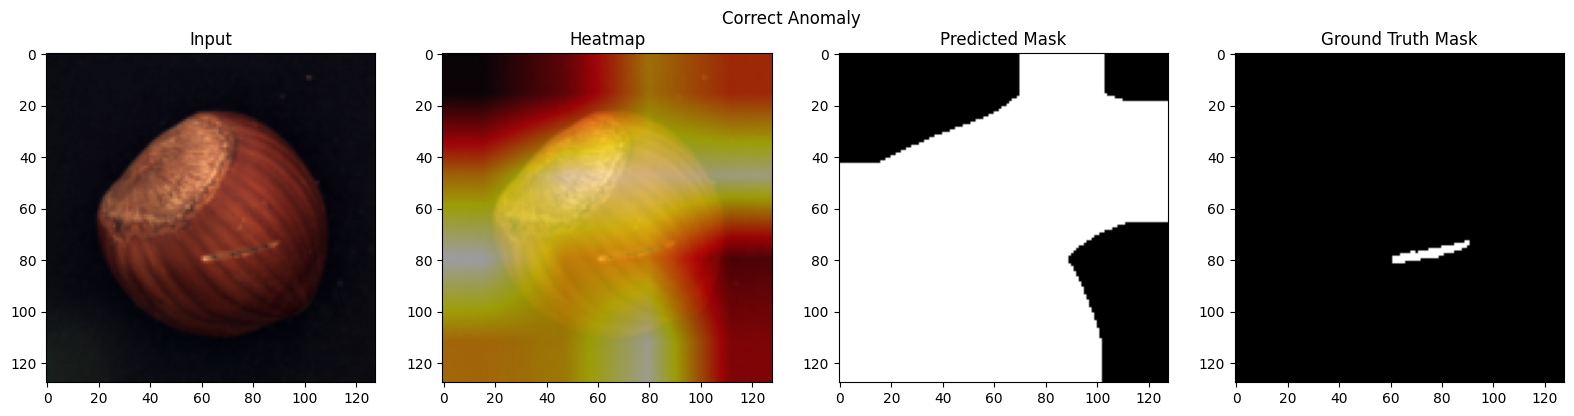

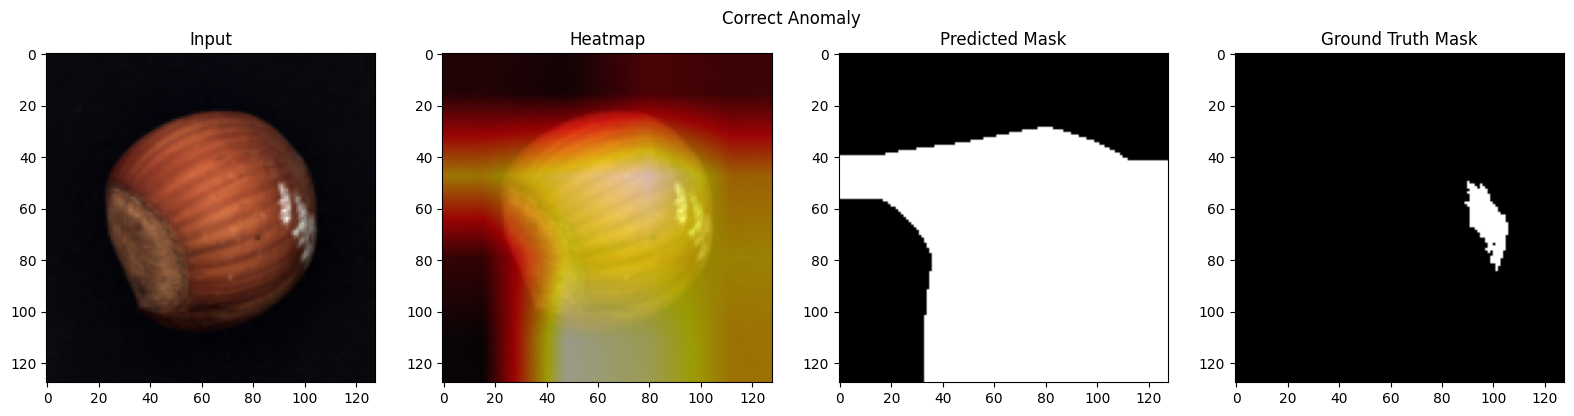

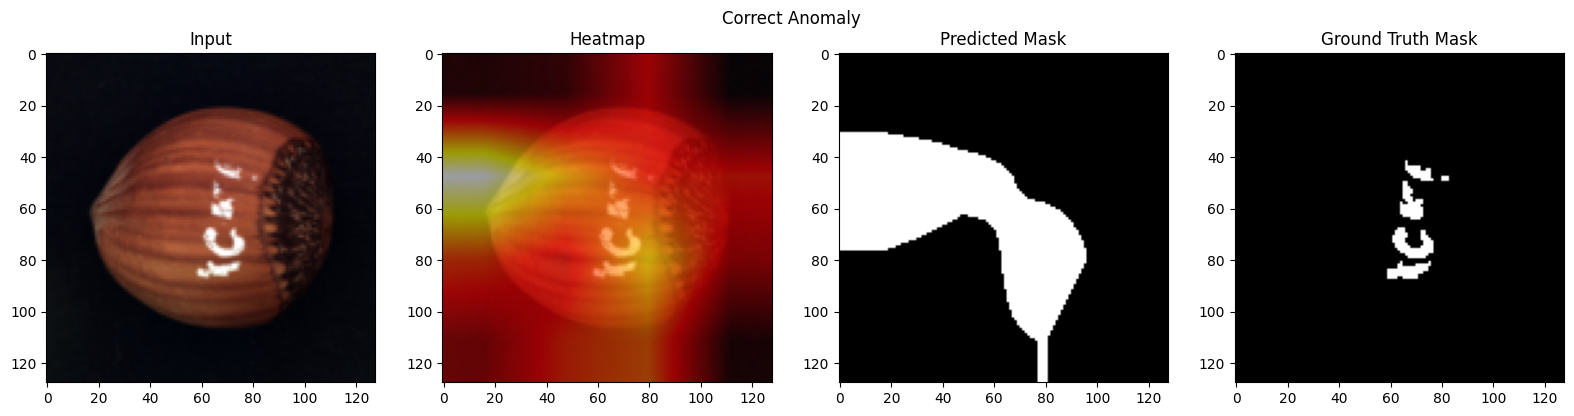


Visualizing Incorrect Anomaly cases...

Visualizing Correct Good cases...

Visualizing Incorrect Good cases...


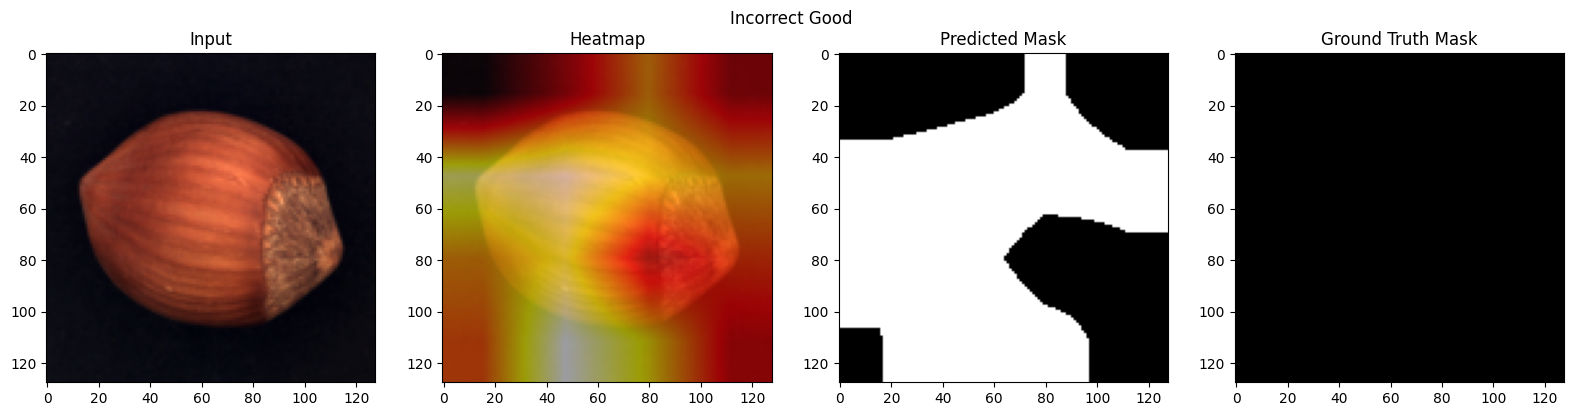

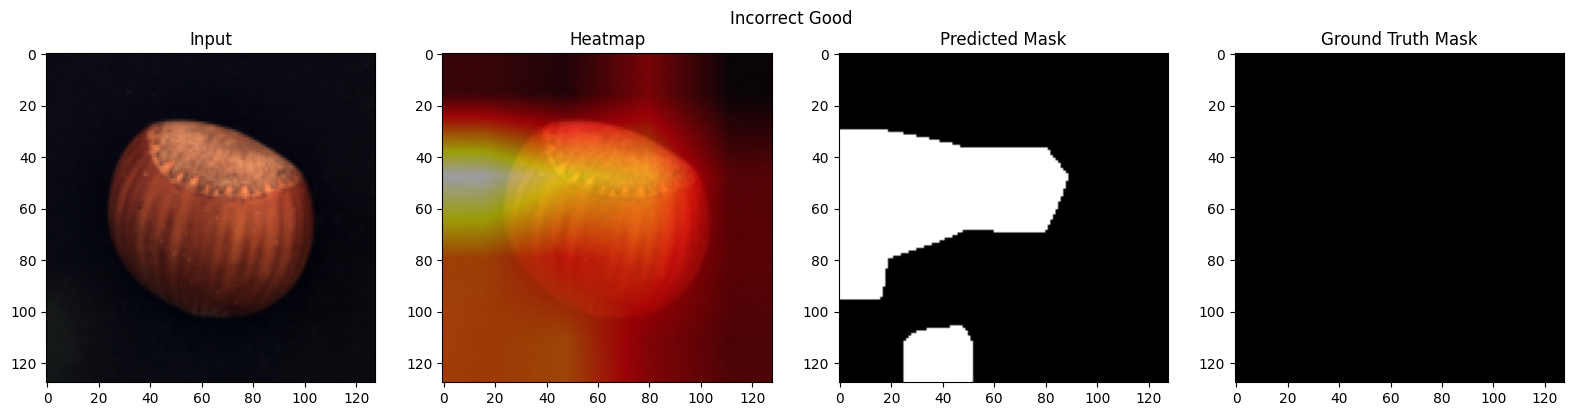

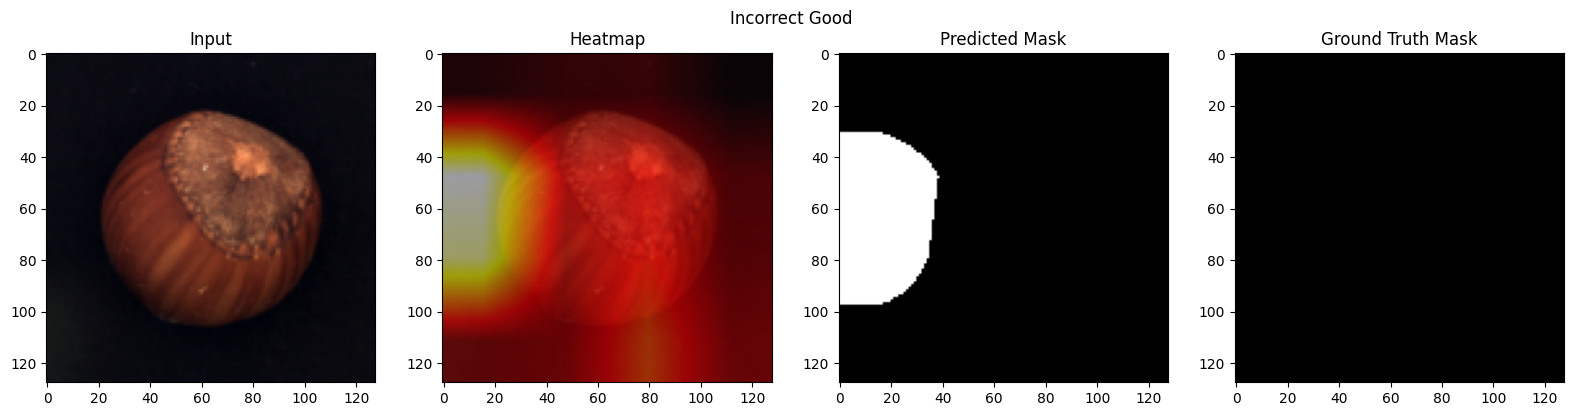

In [10]:
def evaluate_model():
    threshold = 0.5
    y_true, y_pred = [], []

    correct_good = []
    incorrect_good = []
    correct_anomaly = []
    incorrect_anomaly = []

    for img, img_path in test_loader:
        img = img[0].to(device)
        path_str = img_path[0]

        heatmap = run_inference(img, cnn_encoder, qae)
        binary_mask = (heatmap > threshold).astype(np.uint8)
        gt_mask = get_ground_truth_mask(path_str)

        y_true.append(gt_mask.flatten())
        y_pred.append(binary_mask.flatten())

        pred_has_anomaly = binary_mask.sum() > 0
        gt_has_anomaly = gt_mask.sum() > 0

        sample = (img.cpu(), heatmap, binary_mask, gt_mask)

        if gt_has_anomaly:  # Anomalous sample
            if pred_has_anomaly:
                correct_anomaly.append(sample)
            else:
                incorrect_anomaly.append(sample)
        else:  # Good sample
            if not pred_has_anomaly:
                correct_good.append(sample)
            else:
                incorrect_good.append(sample)
                
    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    print("Pixel-wise Evaluation:")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.4f}")
    print(f"IoU      : {jaccard_score(y_true, y_pred):.4f}")

    def visualize_samples(samples, title):
        print(f"\nVisualizing {title} cases...")
        for i in random.sample(range(len(samples)), min(3, len(samples))):
            img, heatmap, binary_mask, gt_mask = samples[i]
            visualize(img, heatmap, binary_mask, gt_mask, title)

    visualize_samples(correct_anomaly, "Correct Anomaly")
    visualize_samples(incorrect_anomaly, "Incorrect Anomaly")
    visualize_samples(correct_good, "Correct Good")
    visualize_samples(incorrect_good, "Incorrect Good")


evaluate_model()

I dont think it learnt anythign at all due to downsampling??